# From VCF to Pleiotropic Markers: A Complete GWAS + mash Pipeline

This notebook walks through a complete analysis starting from raw inputs
(a VCF genotype file and a phenotype file) through per-trait GWAS using
[PANICLE](https://pypi.org/project/panicle/) and then multi-trait shrinkage
with pymash to identify markers with strong **pleiotropic** effects.

**Additional dependencies:** This notebook requires packages not included
in pymash's core dependencies. Install them with:

```bash
pip install panicle pandas matplotlib
```

## Scenario

You have:
- A VCF file with genotypes for hundreds of individuals at millions of markers
- A phenotype file with measurements for multiple traits

You want to find markers that affect **multiple traits simultaneously** (pleiotropy),
with properly calibrated significance measures.

## Pipeline Overview

1. **Load data** — VCF + phenotypes via PANICLE
2. **Run per-trait GWAS** — get effect sizes and standard errors per marker per trait
3. **Build Bhat/Shat matrices** — assemble GWAS results into the format mash expects
4. **Run mash** — joint multi-trait shrinkage
5. **Identify pleiotropic markers** — find markers significant across multiple traits

---

Since we don't have a real 10M-marker VCF in this demo, we'll simulate
genotype and phenotype data that mimics the structure of a real dataset.
All the PANICLE and pymash calls are exactly what you'd use on real data —
only the data generation step would be replaced by file loading.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import panicle
from panicle.utils.data_types import GenotypeMatrix, GenotypeMap, Phenotype
from panicle.data.loaders import load_genotype_vcf, load_phenotype_file, match_individuals

import pymash as mash

## Part 1: Loading Data with PANICLE

### Loading from real files

With real data, you would load your VCF and phenotype file like this:

```python
# Load genotypes from VCF (handles .vcf and .vcf.gz)
geno, sample_ids, geno_map = load_genotype_vcf(
    "my_genotypes.vcf.gz",
    min_maf=0.05,          # filter rare variants
    max_missing=0.2,       # drop markers with >20% missing
    drop_monomorphic=True, # drop invariant sites
)
print(f"Loaded {geno.n_markers} markers for {geno.n_individuals} individuals")

# Load phenotypes (CSV/TSV with ID column + trait columns)
pheno_df = load_phenotype_file("phenotypes.csv")
trait_names = [c for c in pheno_df.columns if c != "ID"]
print(f"Traits: {trait_names}")

# Match individuals between genotype and phenotype
pheno_matched, _, keep_idx, match_info = match_individuals(pheno_df, sample_ids)
print(f"Matched {match_info['n_common']} individuals")
```

### For this demo: simulate data

We'll simulate 500 individuals, 5000 markers, and 8 traits with known
pleiotropic architecture.

In [2]:
# --- Simulate genotype and phenotype data ---
rng = np.random.default_rng(42)

n_ind = 500      # individuals
n_markers = 5000 # markers (use millions for real data)
n_traits = 8     # phenotypes

# Simulate genotype matrix (0/1/2 dosage) with varying allele frequencies
maf = rng.uniform(0.05, 0.5, size=n_markers)
geno_raw = np.zeros((n_ind, n_markers), dtype=np.int8)
for j in range(n_markers):
    geno_raw[:, j] = rng.binomial(2, maf[j], size=n_ind)

# Simulate true effects: most markers are null, some are pleiotropic
n_causal = 50  # causal markers
causal_idx = rng.choice(n_markers, size=n_causal, replace=False)

true_effects = np.zeros((n_markers, n_traits))
for i, idx in enumerate(causal_idx):
    if i < 15:
        # Group 1: affect all traits (fully pleiotropic)
        true_effects[idx, :] = rng.normal(0, 0.3, size=n_traits)
    elif i < 30:
        # Group 2: affect traits 0-3 only (block pleiotropic)
        true_effects[idx, :4] = rng.normal(0, 0.3, size=4)
    elif i < 40:
        # Group 3: affect trait 0 only (trait-specific)
        true_effects[idx, 0] = rng.normal(0, 0.5)
    else:
        # Group 4: affect traits 4-7 only
        true_effects[idx, 4:] = rng.normal(0, 0.3, size=4)

# Simulate phenotypes: Y = X @ beta + noise
X_std = (geno_raw - geno_raw.mean(axis=0)) / np.maximum(geno_raw.std(axis=0), 1e-8)
Y = X_std @ true_effects + rng.normal(0, 1.0, size=(n_ind, n_traits))

print(f"Genotypes: {n_ind} individuals x {n_markers} markers")
print(f"Phenotypes: {n_ind} individuals x {n_traits} traits")
print(f"Causal markers: {n_causal} (of which 15 fully pleiotropic)")

Genotypes: 500 individuals x 5000 markers
Phenotypes: 500 individuals x 8 traits
Causal markers: 50 (of which 15 fully pleiotropic)


### Wrap data in PANICLE types

In [3]:
# Create PANICLE-compatible objects
sample_ids = [f"IND_{i:04d}" for i in range(n_ind)]
snp_ids = [f"SNP_{j:06d}" for j in range(n_markers)]
trait_names = [f"Trait_{t}" for t in range(n_traits)]

# GenotypeMatrix
geno = GenotypeMatrix(geno_raw)

# GenotypeMap (requires columns: SNP, CHROM, POS)
map_df = pd.DataFrame({
    "SNP": snp_ids,
    "CHROM": np.repeat(np.arange(1, 11), n_markers // 10),  # 10 chromosomes
    "POS": np.tile(np.arange(n_markers // 10) * 1000, 10),
})
geno_map = GenotypeMap(map_df)

print(f"GenotypeMatrix: {geno.n_individuals} x {geno.n_markers}")
print(f"GenotypeMap: {geno_map.n_markers} markers on {len(set(geno_map.chromosomes))} chromosomes")

GenotypeMatrix: 500 x 5000
GenotypeMap: 5000 markers on 10 chromosomes


## Part 2: Run Per-Trait GWAS with PANICLE

We run GWAS independently for each trait using PANICLE's Mixed Linear Model
(MLM), which controls for population structure via a kinship matrix.

For each trait, the output includes:
- **Effect sizes** (betas) — goes into mash's `Bhat`
- **Standard errors** — goes into mash's `Shat`

### Compute kinship matrix once

The kinship matrix captures genetic relatedness and is shared across all traits.

In [4]:
K = panicle.PANICLE_K_VanRaden(geno, verbose=False)
print(f"Kinship matrix: {K.shape}")

Kinship matrix: (500, 500)


### Run MLM for each trait

We loop over traits and collect effect sizes and standard errors into matrices.

In [5]:
Bhat = np.zeros((n_markers, n_traits))
Shat = np.zeros((n_markers, n_traits))

for t in range(n_traits):
    # Format phenotype as PANICLE expects: (n x 2) array of [ID, value]
    phe_array = np.column_stack([
        np.arange(n_ind),  # individual indices
        Y[:, t]            # trait values
    ])
    
    # Run MLM
    result = panicle.PANICLE_MLM(
        phe=phe_array,
        geno=geno,
        K=K,
        verbose=False,
    )
    
    Bhat[:, t] = result.effects
    Shat[:, t] = result.se
    
    n_sig = np.sum(result.pvalues < 5e-8)
    print(f"  {trait_names[t]}: {n_sig} genome-wide significant markers")

print(f"\nBhat shape: {Bhat.shape}")
print(f"Shat shape: {Shat.shape}")

  Trait_0: 3 genome-wide significant markers


  Trait_1: 4 genome-wide significant markers
  Trait_2: 3 genome-wide significant markers
  Trait_3: 4 genome-wide significant markers
  Trait_4: 6 genome-wide significant markers
  Trait_5: 7 genome-wide significant markers
  Trait_6: 3 genome-wide significant markers
  Trait_7: 2 genome-wide significant markers

Bhat shape: (5000, 8)
Shat shape: (5000, 8)


### Clean up GWAS output and convert to z-scores

Before passing to mash, handle any edge cases in the GWAS output, then
convert to **z-scores** (Bhat / Shat) with unit standard errors. Working in
z-score space is standard practice (equivalent to `alpha=1` in R mashr)
and enables efficient computation in pymash. Posterior means can be
converted back to effect-size scale afterwards by multiplying by the
original Shat.

In [6]:
# Replace any zero/near-zero SEs (can happen with monomorphic markers)
min_se = 1e-6
small_se = Shat < min_se
if np.any(small_se):
    print(f"Replacing {np.sum(small_se)} near-zero SEs")
    Shat[small_se] = min_se
    Bhat[small_se] = 0.0

# Replace any NaN/Inf
bad = ~np.isfinite(Bhat) | ~np.isfinite(Shat)
if np.any(bad):
    print(f"Replacing {np.sum(bad)} non-finite values")
    Bhat[bad] = 0.0
    Shat[bad] = 1e6  # large SE effectively makes this a missing value

print(f"Bhat range: [{Bhat.min():.4f}, {Bhat.max():.4f}]")
print(f"Shat range: [{Shat.min():.4f}, {Shat.max():.4f}]")

# Convert to z-scores for mash analysis.
# Posterior means can be converted back: pm_effect = pm_z * Shat
Zhat = Bhat / Shat
Shat_ones = np.ones_like(Shat)

print(f"\nZ-score range: [{Zhat.min():.2f}, {Zhat.max():.2f}]")
print(f"Max |Z|: {np.abs(Zhat).max():.2f}")

Bhat range: [-1.7661, 1.5507]
Shat range: [0.1017, 0.3760]

Z-score range: [-9.93, 10.02]
Max |Z|: 10.02


## Part 3: Run mash for Multi-Trait Shrinkage

Now we have J markers x R traits matrices of z-scores (with unit standard errors).
mash will:
1. Learn which patterns of cross-trait sharing are present
2. Shrink the estimates toward the appropriate pattern
3. Provide calibrated significance measures (lfsr) across all traits jointly

At the end, we convert posterior means back to the original effect-size scale.

pymash provides a **workflow module** (`select_training_effects`,
`fit_mash_prior`, `apply_mash_prior`, `mash_train_apply`) that handles
the standard two-stage fitting pattern: train mixture weights on a
subset, then apply the learned model to the full dataset.

### Create strong and random subsets

With millions of markers, you'd use subsets. With our 5000-marker demo
we can use all markers, but we'll demonstrate the subsetting workflow.

In [7]:
# Identify strong signals via condition-by-condition analysis
full_data = mash.mash_set_data(Zhat, Shat_ones)
m1 = mash.mash_1by1(full_data)
strong_idx = mash.get_significant_results(m1, thresh=0.05)
print(f"Strong signals (lfsr < 0.05 in any trait): {len(strong_idx)}")

# Select a random training subset using the workflow module.
# For real data with millions of markers, use n_train=20000-50000.
random_idx = mash.select_training_effects(
    full_data, n_train=min(n_markers, 5000), method="random", seed=42,
)
print(f"Random training subset size: {len(random_idx)}")

Strong signals (lfsr < 0.05 in any trait): 33
Random training subset size: 5000


### Estimate null correlations among traits

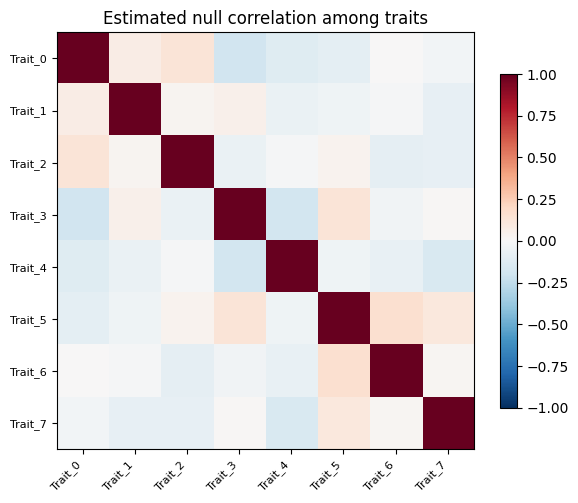

In [8]:
data_rand_temp = mash.mash_set_data(Zhat[random_idx], Shat_ones[random_idx])
Vhat = mash.estimate_null_correlation_simple(data_rand_temp, z_thresh=2.0)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(Vhat, cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xticks(range(n_traits))
ax.set_yticks(range(n_traits))
ax.set_xticklabels(trait_names, rotation=45, ha="right", fontsize=8)
ax.set_yticklabels(trait_names, fontsize=8)
ax.set_title("Estimated null correlation among traits")
fig.colorbar(im, shrink=0.8)
plt.tight_layout()
plt.show()

### Set up data objects with estimated correlations

We need two `MashData` objects:
- `data_all` — the full dataset (for model fitting and posterior computation)
- `data_strong` — just the strong signals (for covariance learning only)

In [9]:
data_all = mash.mash_set_data(Zhat, Shat_ones, V=Vhat)
data_strong = mash.mash_set_data(Zhat[strong_idx], Shat_ones[strong_idx], V=Vhat)

print(f"Full data: {data_all.n_effects} markers x {data_all.n_conditions} traits")
print(f"Strong data: {data_strong.n_effects} markers x {data_strong.n_conditions} traits")

Full data: 5000 markers x 8 traits
Strong data: 33 markers x 8 traits


### Learn data-driven covariances from strong signals

In [10]:
# PCA-based initial covariances
npc = min(5, data_strong.n_conditions)
U_pca = mash.cov_pca(data_strong, npc=npc)

# Refine with Extreme Deconvolution
U_ed = mash.cov_ed(data_strong, U_pca)

# Canonical covariances
U_c = mash.cov_canonical(data_all)

# Combine all
U_all = {**U_ed, **U_c}
print(f"Total covariance matrices: {len(U_all)}")
print(f"  Data-driven (ED): {list(U_ed.keys())}")
print(f"  Canonical: {list(U_c.keys())[:5]}...")

Total covariance matrices: 19
  Data-driven (ED): ['ED_PCA_1', 'ED_PCA_2', 'ED_PCA_3', 'ED_PCA_4', 'ED_PCA_5', 'ED_tPCA']
  Canonical: ['identity', 'singleton_1', 'singleton_2', 'singleton_3', 'singleton_4']...


### Fit the mash model on the training subset

**The Crucial Rule**: fit on the random (unbiased) subset, not the strong signals.

`fit_mash_prior` handles subsetting internally — pass the full `data_all`
and the `random_idx` from `select_training_effects`. It fits with
`outputlevel=1` (mixture weights only, no posteriors).

In [11]:
fitted_g, train_idx, train_result = mash.fit_mash_prior(
    data_all, U_all, train_indices=random_idx,
)
print(f"Log-likelihood (training): {train_result.loglik:.2f}")
print(f"Training subset: {len(train_idx)} markers")

# What sharing patterns did mash learn?
pi_cov = mash.get_estimated_pi(train_result, dimension="cov")
labels = ["null"] + list(U_all.keys())
print("\nTop mixture components:")
for name, w in sorted(zip(labels, pi_cov), key=lambda x: -x[1])[:8]:
    if w > 0.005:
        print(f"  {name}: {w:.3f}")

Log-likelihood (training): -55250.53
Training subset: 5000 markers

Top mixture components:
  null: 0.987
  ED_tPCA: 0.006


### Apply learned model to all markers

`apply_mash_prior` applies the fitted prior (mixture weights + covariances)
to compute shrunken posteriors for every marker, using `fixg=True` internally.

In [12]:
m_all = mash.apply_mash_prior(data_all, fitted_g)

pm_z = mash.get_pm(m_all)    # posterior means in z-score space (J x R)
lfsr = mash.get_lfsr(m_all)  # local false sign rates (J x R)

# Convert posterior means back to the original effect-size scale
pm = pm_z * Shat

print(f"Posterior means (z-score) shape: {pm_z.shape}")
print(f"Posterior means (effect size) shape: {pm.shape}")
print(f"LFSR shape: {lfsr.shape}")

Posterior means (z-score) shape: (5000, 8)
Posterior means (effect size) shape: (5000, 8)
LFSR shape: (5000, 8)


### One-shot alternative: `mash_train_apply`

The steps above (select training set → fit prior → apply) can be combined
into a single call with `mash_train_apply`:

```python
result = mash.mash_train_apply(
    data_all, U_all,
    n_train=20000,              # auto-select random training subset
    select_method="random",     # or "topz_random" for top-|z| + random mix
)
pm_z  = mash.get_pm(result.apply_result)
lfsr  = mash.get_lfsr(result.apply_result)
print(f"Trained on {len(result.train_indices)} markers")
```

### For large datasets: batch processing

With 10M markers, apply the fitted model in batches to manage memory:

```python
batch_size = 50000
all_pm_z, all_lfsr = [], []

for start in range(0, Zhat.shape[0], batch_size):
    end = min(start + batch_size, Zhat.shape[0])
    data_batch = mash.mash_set_data(Zhat[start:end], Shat_ones[start:end], V=Vhat)
    m_batch = mash.apply_mash_prior(data_batch, fitted_g)
    all_pm_z.append(mash.get_pm(m_batch))
    all_lfsr.append(mash.get_lfsr(m_batch))
    print(f"  Processed markers {start:,}-{end:,}")

pm_z = np.vstack(all_pm_z)
lfsr = np.vstack(all_lfsr)

# Convert back to effect-size scale
pm = pm_z * Shat
```

## Part 4: Identify Pleiotropic Markers

### Count significant traits per marker

In [13]:
lfsr_thresh = 0.05
n_sig_traits = np.sum(lfsr < lfsr_thresh, axis=1)

print("Markers by number of significant traits:")
for k in range(n_traits + 1):
    count = np.sum(n_sig_traits == k)
    if count > 0:
        print(f"  {k} traits: {count} markers")

print(f"\nPleiotropic (>=2 traits): {np.sum(n_sig_traits >= 2)} markers")
print(f"Highly pleiotropic (>=4 traits): {np.sum(n_sig_traits >= 4)} markers")

Markers by number of significant traits:
  0 traits: 4965 markers
  1 traits: 3 markers
  2 traits: 5 markers
  3 traits: 6 markers
  4 traits: 6 markers
  5 traits: 6 markers
  6 traits: 2 markers
  7 traits: 2 markers
  8 traits: 5 markers

Pleiotropic (>=2 traits): 32 markers
Highly pleiotropic (>=4 traits): 21 markers


### Examine top pleiotropic markers

In [14]:
# Rank markers by number of significant traits, then by min lfsr
min_lfsr = np.min(lfsr, axis=1)
sort_key = -(n_sig_traits * 1000 - min_lfsr)  # primary: n_traits, secondary: lfsr
top_idx = np.argsort(sort_key)

print(f"{'Marker':<15} {'N traits':>8} {'Min LFSR':>10}  Significant in")
print("-" * 70)
for rank, idx in enumerate(top_idx[:15]):
    sig_traits = [trait_names[t] for t in range(n_traits) if lfsr[idx, t] < lfsr_thresh]
    is_causal = "*" if idx in causal_idx else " "
    print(f"{snp_ids[idx]}{is_causal} {n_sig_traits[idx]:>7}  {min_lfsr[idx]:>10.4f}  {', '.join(sig_traits)}")

print("\n* = truly causal in simulation")

Marker          N traits   Min LFSR  Significant in
----------------------------------------------------------------------
SNP_001374*       8      0.0000  Trait_0, Trait_1, Trait_2, Trait_3, Trait_4, Trait_5, Trait_6, Trait_7
SNP_004129*       8      0.0000  Trait_0, Trait_1, Trait_2, Trait_3, Trait_4, Trait_5, Trait_6, Trait_7
SNP_001128*       8      0.0000  Trait_0, Trait_1, Trait_2, Trait_3, Trait_4, Trait_5, Trait_6, Trait_7
SNP_001504*       8      0.0000  Trait_0, Trait_1, Trait_2, Trait_3, Trait_4, Trait_5, Trait_6, Trait_7
SNP_004812*       8      0.0000  Trait_0, Trait_1, Trait_2, Trait_3, Trait_4, Trait_5, Trait_6, Trait_7
SNP_001938*       7      0.0000  Trait_0, Trait_1, Trait_2, Trait_3, Trait_5, Trait_6, Trait_7
SNP_003852*       7      0.0000  Trait_0, Trait_1, Trait_3, Trait_4, Trait_5, Trait_6, Trait_7
SNP_004784*       6      0.0000  Trait_0, Trait_3, Trait_4, Trait_5, Trait_6, Trait_7
SNP_000124*       6      0.0001  Trait_0, Trait_1, Trait_3, Trait_5, Trait_6, Tra

### Visualize posterior effects for a top pleiotropic marker

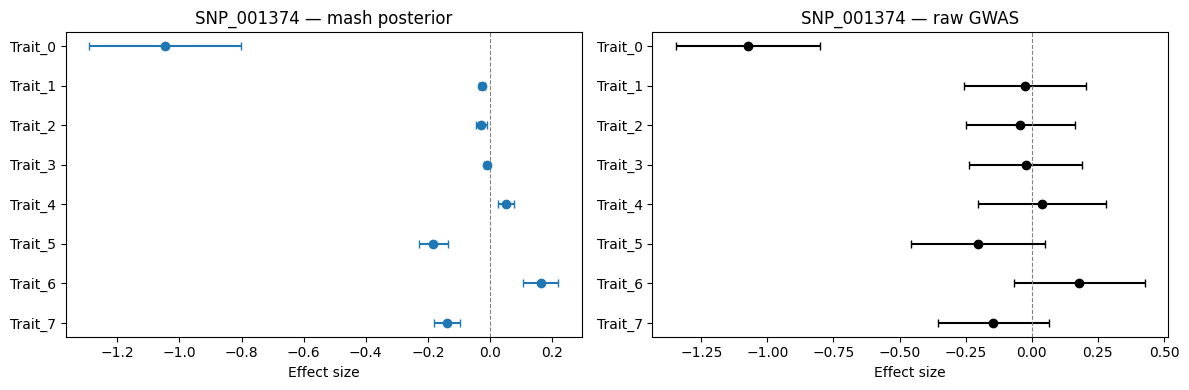

In [15]:
# Forest plot for the most pleiotropic marker
best = top_idx[0]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

y = np.arange(n_traits)

# Mash posterior (shrunken, converted to effect-size scale)
psd = mash.get_psd(m_all)
pm_best = pm[best]
psd_best = psd[best] * Shat[best]  # convert posterior SD to effect-size scale
axes[0].errorbar(pm_best, y, xerr=1.96 * psd_best, fmt="o", color="C0", capsize=3)
axes[0].axvline(0, color="grey", linestyle="--", linewidth=0.8)
axes[0].set_yticks(y)
axes[0].set_yticklabels(trait_names)
axes[0].set_xlabel("Effect size")
axes[0].set_title(f"{snp_ids[best]} — mash posterior")
axes[0].invert_yaxis()

# Raw GWAS estimates (unshrunken)
axes[1].errorbar(Bhat[best], y, xerr=1.96 * Shat[best], fmt="o", color="black", capsize=3)
axes[1].axvline(0, color="grey", linestyle="--", linewidth=0.8)
axes[1].set_yticks(y)
axes[1].set_yticklabels(trait_names)
axes[1].set_xlabel("Effect size")
axes[1].set_title(f"{snp_ids[best]} — raw GWAS")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

### Pairwise trait sharing

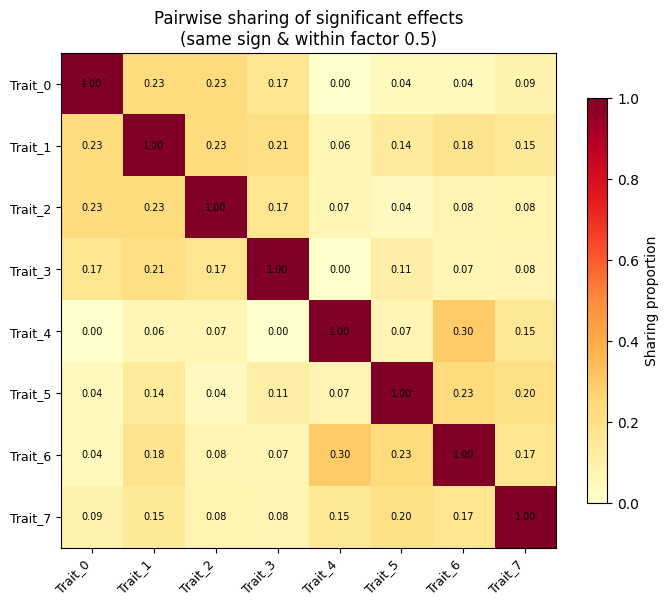

In [16]:
sharing = mash.get_pairwise_sharing(m_all, factor=0.5)

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(sharing, vmin=0, vmax=1, cmap="YlOrRd")
ax.set_xticks(range(n_traits))
ax.set_yticks(range(n_traits))
ax.set_xticklabels(trait_names, rotation=45, ha="right", fontsize=9)
ax.set_yticklabels(trait_names, fontsize=9)
for i in range(n_traits):
    for j in range(n_traits):
        val = sharing[i, j]
        if np.isfinite(val):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7)
fig.colorbar(im, shrink=0.8, label="Sharing proportion")
ax.set_title("Pairwise sharing of significant effects\n(same sign & within factor 0.5)")
plt.tight_layout()
plt.show()

### Compare mash shrinkage to raw GWAS

mash borrows strength across traits, so its estimates are more accurate
than per-trait GWAS alone. Let's compare.

In [17]:
# RMSE vs true effects for causal markers
rmse_raw = np.sqrt(np.mean((Bhat[causal_idx] - true_effects[causal_idx]) ** 2))
rmse_mash = np.sqrt(np.mean((pm[causal_idx] - true_effects[causal_idx]) ** 2))

print(f"RMSE at causal markers:")
print(f"  Raw GWAS:  {rmse_raw:.4f}")
print(f"  mash:      {rmse_mash:.4f}")
print(f"  Improvement: {(1 - rmse_mash / rmse_raw) * 100:.1f}%")

RMSE at causal markers:
  Raw GWAS:  0.2573
  mash:      0.2183
  Improvement: 15.2%


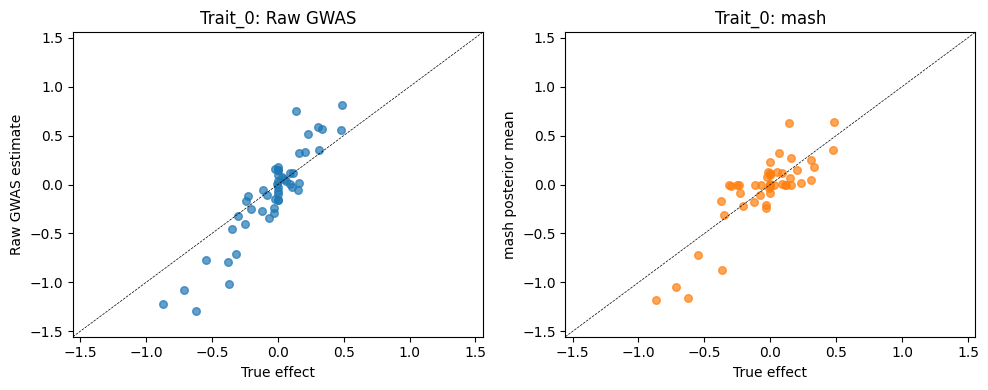

In [18]:
# Scatter: mash posterior vs true effect (for one trait)
t = 0
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

lim = max(np.abs(true_effects[causal_idx, t]).max(),
          np.abs(Bhat[causal_idx, t]).max()) * 1.2

axes[0].scatter(true_effects[causal_idx, t], Bhat[causal_idx, t], alpha=0.7, s=30)
axes[0].plot([-lim, lim], [-lim, lim], "k--", linewidth=0.5)
axes[0].set_xlabel("True effect")
axes[0].set_ylabel("Raw GWAS estimate")
axes[0].set_title(f"{trait_names[t]}: Raw GWAS")
axes[0].set_xlim(-lim, lim)
axes[0].set_ylim(-lim, lim)

axes[1].scatter(true_effects[causal_idx, t], pm[causal_idx, t], alpha=0.7, s=30, color="C1")
axes[1].plot([-lim, lim], [-lim, lim], "k--", linewidth=0.5)
axes[1].set_xlabel("True effect")
axes[1].set_ylabel("mash posterior mean")
axes[1].set_title(f"{trait_names[t]}: mash")
axes[1].set_xlim(-lim, lim)
axes[1].set_ylim(-lim, lim)

plt.tight_layout()
plt.show()

## Part 5: Export Results

Save the results for downstream analysis.

In [19]:
# Build a results DataFrame
results_df = pd.DataFrame({
    "SNP": snp_ids,
    "Chr": map_df["CHROM"].values,
    "Pos": map_df["POS"].values,
    "n_sig_traits": n_sig_traits,
    "min_lfsr": min_lfsr,
})

# Add per-trait posterior means and lfsr
for t, name in enumerate(trait_names):
    results_df[f"pm_{name}"] = pm[:, t]
    results_df[f"lfsr_{name}"] = lfsr[:, t]

# Sort by pleiotropy
results_df = results_df.sort_values(
    ["n_sig_traits", "min_lfsr"], ascending=[False, True]
)

print("Top 10 pleiotropic markers:")
print(results_df.head(10)[["SNP", "Chr", "Pos", "n_sig_traits", "min_lfsr"]].to_string(index=False))

# Save to CSV
# results_df.to_csv("mash_results.csv", index=False)

Top 10 pleiotropic markers:
       SNP  Chr    Pos  n_sig_traits     min_lfsr
SNP_001374    3 374000             8 3.292921e-12
SNP_004129    9 129000             8 1.292482e-10
SNP_001128    3 128000             8 1.180890e-06
SNP_001504    4   4000             8 3.394122e-06
SNP_004812   10 312000             8 7.722191e-06
SNP_001938    4 438000             7 1.268427e-22
SNP_003852    8 352000             7 4.491753e-10
SNP_004784   10 284000             6 6.918614e-09
SNP_000124    1 124000             6 1.078923e-04
SNP_000997    2 497000             5 1.032507e-14


## Summary

This pipeline:

1. **Loaded genotypes** from a VCF file and phenotypes from a CSV using PANICLE
2. **Ran per-trait MLM GWAS** with PANICLE, extracting Bhat and Shat matrices
3. **Estimated null correlations** among traits from a random marker subset
4. **Learned effect-sharing patterns** from strong signals (PCA + ED)
5. **Fit the mash model** on a random training subset using `fit_mash_prior`
6. **Applied the learned model** to all markers using `apply_mash_prior`
7. **Identified pleiotropic markers** significant across multiple traits

### Workflow module functions used

| Function | Purpose |
|----------|---------|
| `select_training_effects` | Select a random (or top-z + random) training subset |
| `fit_mash_prior` | Fit mixture weights on the training subset (`outputlevel=1`) |
| `apply_mash_prior` | Apply fitted model to all markers (`fixg=True`) |
| `mash_train_apply` | One-shot wrapper combining all three steps |

### Key advantages over per-trait GWAS alone

- **Better calibrated**: mash accounts for the correlation structure among traits
- **More powerful**: borrowing information across traits recovers effects too weak
  to detect in any single trait
- **Interpretable**: the mixture proportions reveal which sharing patterns dominate,
  and the pairwise sharing matrix shows which traits tend to share effects

### Scaling to 10M markers

For a real maize dataset with 10M markers:

- **GWAS step**: run PANICLE MLM per trait (parallelizable across traits/chromosomes)
- **Strong set**: use ~5-30k LD-pruned lead SNPs (one per locus) for covariance learning
- **Random set**: use `select_training_effects(data, n_train=20000)` for model fitting
- **Posteriors**: apply `apply_mash_prior` in batches of 50k with the fitted model
- **Memory**: each batch needs only the Bhat/Shat slice + the fitted model